✅ Time condition satisfied. Displaying graph...


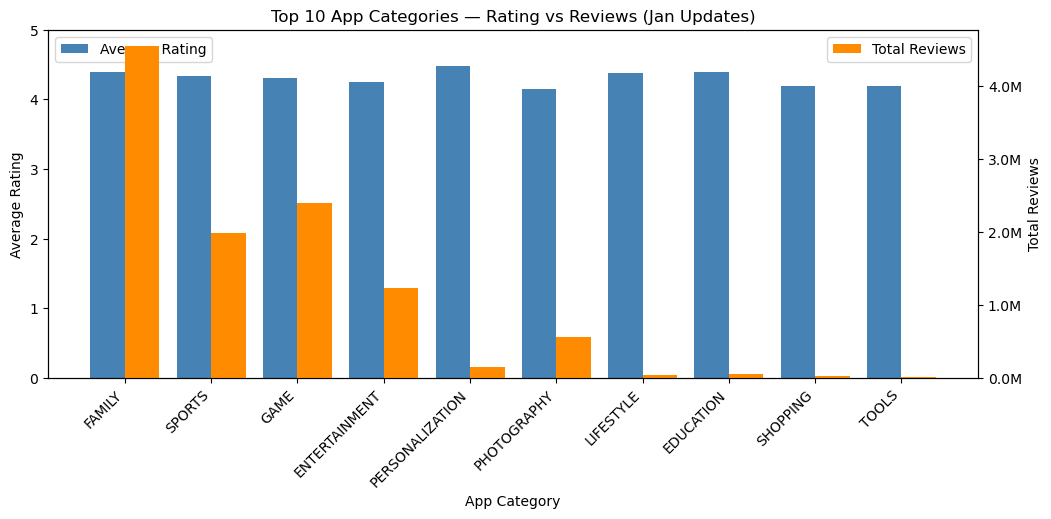

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from matplotlib.ticker import FuncFormatter

task_time = "16:00"  

task_time = datetime.strptime(task_time, "%H:%M").time()

start_time = datetime.strptime("15:00", "%H:%M").time()
end_time   = datetime.strptime("17:00", "%H:%M").time()

df = pd.read_csv("Play Store Data.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_")

df['Last_Updated'] = pd.to_datetime(df['Last_Updated'], errors='coerce')

def convert_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(convert_size)

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df = df.dropna(subset=['Category','Rating','Reviews','Installs','Size_MB','Last_Updated'])

filtered_df = df[
    (df['Rating'] >= 4.0) &
    (df['Size_MB'] >= 10) &
    (df['Last_Updated'].dt.month == 1)
]

top_categories = (
    filtered_df
    .groupby('Category', as_index=False)
    .agg({
        'Installs': 'sum',
        'Rating': 'mean',
        'Reviews': 'sum'
    })
    .sort_values(by='Installs', ascending=False)
    .head(10)
)

if start_time <= task_time <= end_time:

    print("✅ Time condition satisfied. Displaying graph...")

    x = range(len(top_categories))
    width = 0.4

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()

    ax1.bar(
        x,
        top_categories['Rating'],
        width=width,
        label='Average Rating',
        color='steelblue'
    )
    ax1.set_ylabel("Average Rating")
    ax1.set_ylim(0, 5)

    ax2.bar(
        [i + width for i in x],
        top_categories['Reviews'],
        width=width,
        label='Total Reviews',
        color='darkorange'
    )
    ax2.set_ylabel("Total Reviews")
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))

    ax1.set_xticks([i + width/2 for i in x])
    ax1.set_xticklabels(top_categories['Category'], rotation=45, ha='right')
    ax1.set_xlabel("App Category")

    plt.title("Top 10 App Categories — Rating vs Reviews (Jan Updates)")

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.subplots_adjust(bottom=0.30)
    plt.show()

else:
    print("⏰ Chart will NOT be displayed (Allowed only between 3 PM and 5 PM IST).")
    fig.show()

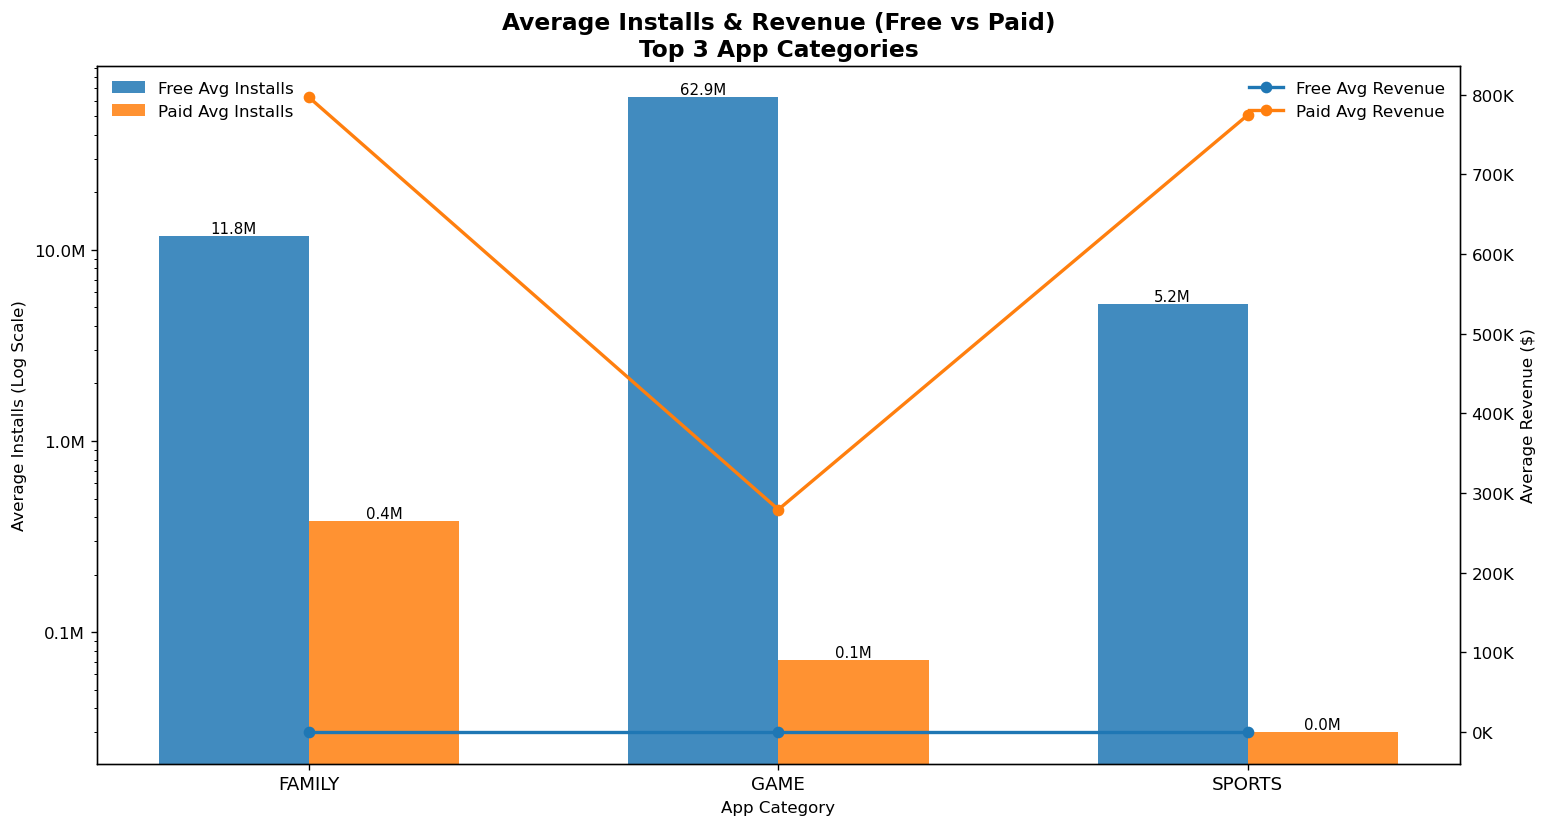

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
from matplotlib.ticker import FuncFormatter

df = pd.read_csv("Play Store Data.csv")

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df['Revenue'] = df['Price'] * df['Installs']
df.loc[df['Type'] == 'Free', 'Revenue'] = 0

def clean_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M',''))
        elif 'k' in size:
            return float(size.replace('k','')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(clean_size)

df['Android_Ver_Clean'] = df['Android Ver'].astype(str).str.extract(r'(\d+\.\d+)')
df['Android_Ver_Clean'] = pd.to_numeric(df['Android_Ver_Clean'], errors='coerce')

df['App_Length'] = df['App'].astype(str).str.len()

filtered_df = df[
    (df['Installs'] >= 10000) &
    (df['Android_Ver_Clean'] > 4.0) &
    (df['Size_MB'] > 15) &
    (df['Content Rating'] == 'Everyone') &
    (df['App_Length'] <= 30)
]

filtered_df = filtered_df[
    (filtered_df['Type'] == 'Free') |
    ((filtered_df['Type'] == 'Paid') & (filtered_df['Revenue'] >= 10000))
]

top_categories = filtered_df['Category'].value_counts().head(3).index
top_df = filtered_df[filtered_df['Category'].isin(top_categories)]

grouped = (
    top_df
    .groupby(['Category','Type'])
    .agg({'Installs':'mean','Revenue':'mean'})
    .reset_index()
)

pivot_installs = grouped.pivot(index='Category', columns='Type', values='Installs').fillna(0)
pivot_revenue  = grouped.pivot(index='Category', columns='Type', values='Revenue').fillna(0)

for col in ['Free','Paid']:
    if col not in pivot_installs:
        pivot_installs[col] = 0
    if col not in pivot_revenue:
        pivot_revenue[col] = 0

categories = pivot_installs.index
x = range(len(categories))
width = 0.32

manual_time = "13:30"  
user_time = datetime.strptime(manual_time, "%H:%M").time()

start_time = time(13, 0)
end_time   = time(14, 0)

def millions(x, pos):
    return f'{x/1_000_000:.1f}M'

def thousands(x, pos):
    return f'{x/1_000:.0f}K'

if start_time <= user_time <= end_time:

    fig, ax1 = plt.subplots(figsize=(13,7), dpi=120)
    ax2 = ax1.twinx()

    # Bars
    free_bars = ax1.bar(
        [i - width/2 for i in x],
        pivot_installs['Free'],
        width=width,
        label='Free Avg Installs',
        alpha=0.85
    )

    paid_bars = ax1.bar(
        [i + width/2 for i in x],
        pivot_installs['Paid'],
        width=width,
        label='Paid Avg Installs',
        alpha=0.85
    )


    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(FuncFormatter(millions))
    ax1.set_ylabel("Average Installs (Log Scale)")

    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, fontsize=11)
    ax1.set_xlabel("App Category")

    ax2.plot(x, pivot_revenue['Free'], marker='o', linewidth=2, label='Free Avg Revenue')
    ax2.plot(x, pivot_revenue['Paid'], marker='o', linewidth=2, label='Paid Avg Revenue')
    ax2.yaxis.set_major_formatter(FuncFormatter(thousands))
    ax2.set_ylabel("Average Revenue ($)")

    for bar in free_bars + paid_bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(
                bar.get_x() + bar.get_width()/2,
                height,
                f'{height/1_000_000:.1f}M',
                ha='center',
                va='bottom',
                fontsize=9
            )

    ax1.legend(loc='upper left', frameon=False)
    ax2.legend(loc='upper right', frameon=False)

    plt.title(
        "Average Installs & Revenue (Free vs Paid)\nTop 3 App Categories",
        fontsize=14,
        weight='bold'
    )

    plt.tight_layout()
    plt.show()

else:
    print("⏰ Chart visible only between 1 PM – 2 PM IST")

In [19]:
import pandas as pd
import plotly.express as px
from datetime import time

df = pd.read_csv("Play Store Data.csv")

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
df = df.dropna(subset=['Category', 'Installs'])

df = df[~df['Category'].str.startswith(('A','C','G','S'))]

top5 = (
    df.groupby('Category', as_index=False)['Installs']
    .sum()
    .sort_values(by='Installs', ascending=False)
    .head(5)
)

top5 = top5[top5['Installs'] > 1_000_000]

country_map = ['USA', 'IND', 'BRA', 'DEU', 'AUS']
top5['iso_alpha'] = country_map[:len(top5)]

given_time = time(18, 0)   

START_TIME = time(18, 0)   
END_TIME   = time(20, 0)   

if START_TIME <= given_time <= END_TIME:

    fig = px.choropleth(
        top5,
        locations='iso_alpha',
        locationmode='ISO-3',
        color='Installs',
        hover_name='Category',
        color_continuous_scale='Plasma',
        title='Global App Installs by Category (Top 5)'
    )

    fig.update_layout(
        geo=dict(showframe=False, showcoastlines=True),
        margin=dict(l=0, r=0, t=50, b=0)
    )

    fig.show()

else:
    print("⛔ Visualization available only between 6:00 PM and 8:00 PM IST.")

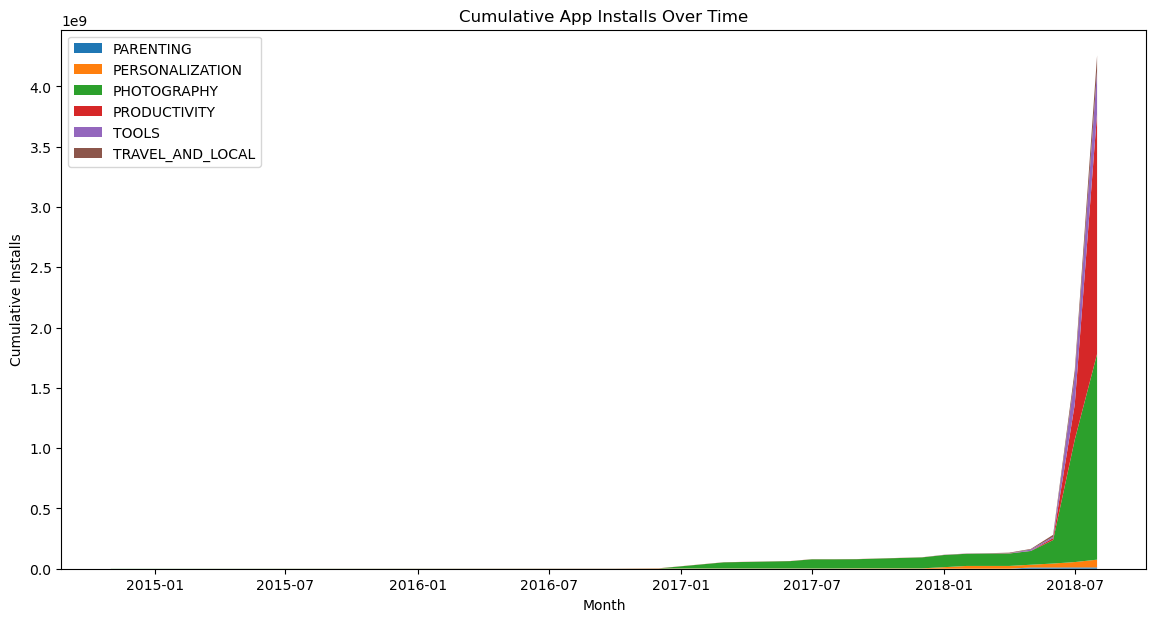

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time

df = pd.read_csv("Play Store Data.csv")

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

def clean_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(clean_size)

filtered = df[
    (df['Rating'] >= 4.2) &
    (df['Reviews'] > 1000) &
    (df['Size_MB'].between(20, 80)) &
    (df['Category'].str.startswith(('T', 'P'))) &
    (~df['App'].astype(str).str.contains(r'\d', regex=True))
].dropna(subset=['Last Updated'])

filtered['Category'] = filtered['Category'].replace({
    'Travel & Local': 'Voyage et Local',   
    'Productivity': 'Productividad',       
    'Photography': '写真'                   
})

filtered['Month'] = filtered['Last Updated'].dt.to_period('M').dt.to_timestamp()

grouped = (
    filtered
    .groupby(['Month', 'Category'])['Installs']
    .sum()
    .reset_index()
)

pivot = grouped.pivot(index='Month', columns='Category', values='Installs').fillna(0)

pivot_cum = pivot.cumsum()

given_time = time(17, 0)  

START_TIME = time(16, 0)
END_TIME = time(18, 0)

if START_TIME <= given_time <= END_TIME:

    plt.figure(figsize=(14, 7))

    plt.stackplot(
        pivot_cum.index,
        pivot_cum.T.values,        
        labels=pivot_cum.columns  
    )

    plt.legend(loc='upper left')
    plt.title("Cumulative App Installs Over Time")
    plt.xlabel("Month")
    plt.ylabel("Cumulative Installs")

    plt.show()

else:
    print("⚠️ Visualization available only between 4:00 PM and 6:00 PM IST.")

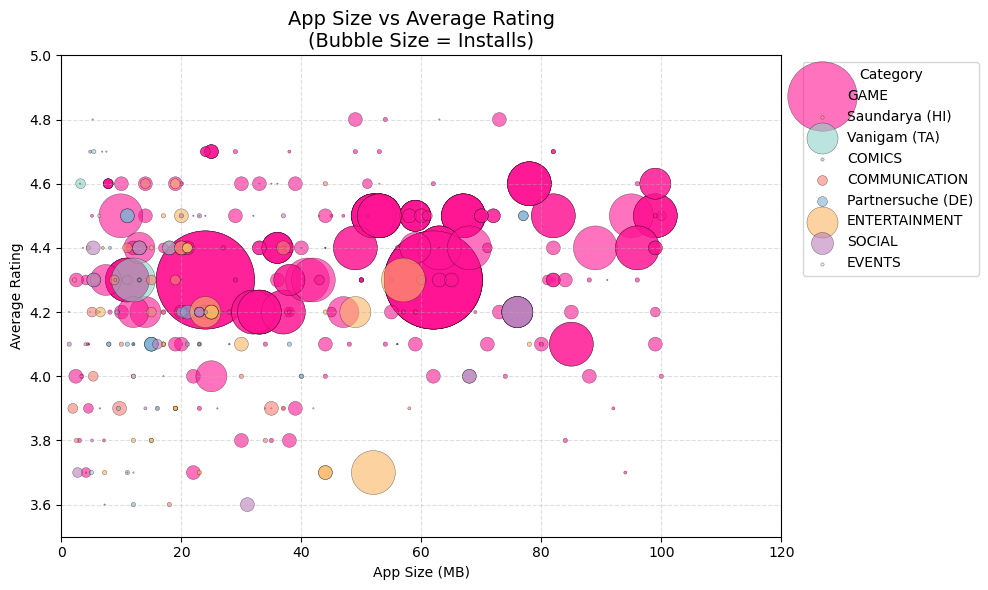

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time

user_time_input = "18:00"   

user_time = time(
    int(user_time_input.split(":")[0]),
    int(user_time_input.split(":")[1])
)

START_TIME = time(17, 0)  
END_TIME   = time(19, 0)  

if not (START_TIME <= user_time <= END_TIME):
    print("⚠️ Bubble chart available only between 5 PM and 7 PM IST.")

else:
    df = pd.read_csv("Play Store Data.csv")

    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace(r'[+,]', '', regex=True)
    )
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

    def convert_size(size):
        if pd.isna(size):
            return None
        size = str(size)
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
        return None

    df['Size_MB'] = df['Size'].apply(convert_size)

    allowed_categories = [
        'GAME', 'BEAUTY', 'BUSINESS', 'COMICS',
        'COMMUNICATION', 'DATING', 'ENTERTAINMENT',
        'SOCIAL', 'EVENTS'
    ]

    filtered = df[
        (df['Rating'] > 3.5) &
        (df['Category'].isin(allowed_categories)) &
        (df['Reviews'] > 500) &
        (~df['App'].str.contains('S', case=False, na=False)) &
        (df['Installs'] > 50000) &
        (df['Size_MB'].between(1, 120))
    ].copy()

    translation = {
        'BEAUTY': 'Saundarya (HI)',
        'BUSINESS': 'Vanigam (TA)',
        'DATING': 'Partnersuche (DE)'
    }

    filtered['Category_Label'] = filtered['Category'].map(
        lambda x: translation.get(x, x)
    )

    color_map = {
        'GAME': 'deeppink',
        'BEAUTY': '#ffb347',
        'BUSINESS': '#8dd3c7',
        'COMICS': '#bebada',
        'COMMUNICATION': '#fb8072',
        'DATING': '#80b1d3',
        'ENTERTAINMENT': '#fdb462',
        'SOCIAL': '#bc80bd',
        'EVENTS': '#ccebc5'
    }

    plt.figure(figsize=(10, 6))

    for category in allowed_categories:
        subset = filtered[filtered['Category'] == category]
        if subset.empty:
            continue

        plt.scatter(
            subset['Size_MB'],
            subset['Rating'],
            s=subset['Installs'] / 100000,   
            alpha=0.6,
            color=color_map.get(category),
            edgecolors='black',
            linewidths=0.3,
            label=translation.get(category, category),
            clip_on=True                      
        )

    plt.xlim(0, 120)
    plt.ylim(3.5, 5.0)

    plt.title("App Size vs Average Rating\n(Bubble Size = Installs)", fontsize=14)
    plt.xlabel("App Size (MB)")
    plt.ylabel("Average Rating")

    plt.legend(
        title="Category",
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )

    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [15]:
import pandas as pd
import plotly.express as px
from datetime import datetime, time

def show_installs_time_series(df, input_time_ist):
    
    user_time = datetime.strptime(input_time_ist, "%H:%M").time()
    start_time = time(18, 0)
    end_time = time(21, 0)

    if not (start_time <= user_time <= end_time):
        print("⚠️ Warning: This chart is available only between 6 PM and 9 PM IST.")
        return

    df = df.copy()
    
    def clean_installs(val):
        try:
            return int(float(str(val).replace(",", "").replace("+", "")))
        except:
            return None

    df["Installs_Clean"] = df["Installs"].apply(clean_installs)

    df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce")

    df["Last Updated"] = pd.to_datetime(df["Last Updated"], errors="coerce")

    df = df.dropna(subset=["Installs_Clean", "Last Updated", "Reviews"])


    df = df[
        (df["Reviews"] > 500) &
        (~df["App"].astype(str).str.upper().str.startswith(("X", "Y", "Z"))) &
        (~df["App"].astype(str).str.contains("S", case=False)) &
        (df["Category"].astype(str).str.upper().str.startswith(("E", "C", "B")))
    ]

    if df.empty:
        print("⚠️ Warning: Time condition satisfied, but no data matches the filters.")
        return

    category_translation = {
        "BEAUTY": "सौंदर्य",
        "BUSINESS": "வணிகம்",
        "DATING": "Partnersuche"
    }

    df["Category_Display"] = df["Category"].str.upper().replace(category_translation)

    df["Month"] = df["Last Updated"].dt.to_period("M").dt.to_timestamp()

    grouped = (
        df.groupby(["Month", "Category_Display"])["Installs_Clean"]
        .sum()
        .reset_index()
        .sort_values("Month")
    )

    fig = px.line(
        grouped,
        x="Month",
        y="Installs_Clean",
        color="Category_Display",
        title="Total Installs Trend Over Time by Category"
    )

    fig.update_layout(
        xaxis_title="Month",
        yaxis_title="Total Installs",
        template="plotly_white"
    )

    fig.show()
    
show_installs_time_series(df, "18:00")